In [10]:
# general imports
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import toolz as fp
#import nltk
import warnings
# configuration
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'svg' 
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
nltk.download('rslp')
nltk.download('stopwords');

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/juliano.garcia/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliano.garcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.  Carregando o dataset

O conjunto de dados utilizado é um conjunto de tweets em língua portuguesa, retirado do github [minerando dados](https://github.com/minerandodados/mdrepo)

In [11]:
dataset = pd.read_csv("./Tweets_Mg.csv", encoding='utf-8')
dataset.head()
dataset.shape

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(8199, 26)

Para simplificar, vamos transformar em um problema de classificação binária: tweets com sentimentos negativos serão considerados 0, positivos como 1, e os neutros tem 50% de chance de cair em uma das duas categorias. Também iremos renomear as colunas para facilitar, além de manter somente as colunas que vamos utilizar para criar o modelo.

In [12]:
np.random.seed(42)
df = (dataset
               .rename(columns={"Created At": "publication_date",
                                "Text": "tweet",                                
                                "Retweet Count" : "num_retweets",
                                "Username": "username",
                                "Classificacao": "sentiment"})
               .loc[:, ["publication_date", "tweet", "num_retweets",  "username", "sentiment"]])
df["publication_date"] = pd.to_datetime(df["publication_date"],infer_datetime_format=True)
df["sentiment"] = df["sentiment"].replace({"Negativo": 0, "Neutro": np.random.choice([0, 1]), "Positivo": 1})

df.head()

,publication_date,tweet,num_retweets,username,sentiment
0,2017-01-08 01:22:05+00:00,���⛪ @ Catedral de Santo Antônio - Governador ...,0,Leonardo C Schneider,0
1,2017-01-08 01:49:01+00:00,"� @ Governador Valadares, Minas Gerais https:/...",0,Wândell,0
2,2017-01-08 01:01:46+00:00,"�� @ Governador Valadares, Minas Gerais https:...",0,Wândell,0
3,2017-01-04 21:43:51+00:00,��� https://t.co/BnDsO34qK0,0,Ana estudando,0
4,2017-01-09 15:08:21+00:00,��� PSOL vai questionar aumento de vereadores ...,0,Emily,0


In [13]:
df.isna().sum()

publication_date    0
tweet               0
num_retweets        0
username            0
sentiment           0
dtype: int64

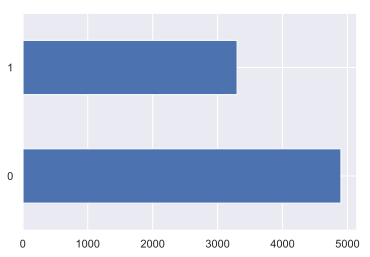

In [14]:
df["sentiment"].value_counts().plot.barh();

Usando a biblioteca `nltk`, podemos verificar facilmente as palavras mais frequentes dos tweets; Abaixo estamos olhando as 25 palavras (com mais de 3 caracteres) mais frequentes.

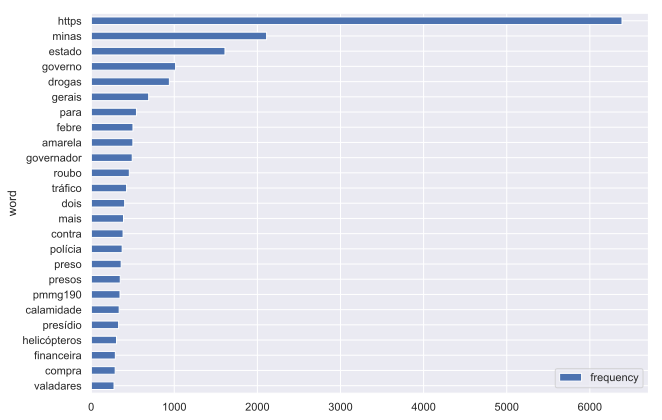

In [15]:
tweet_words = nltk.tokenize.word_tokenize(df["tweet"].drop_duplicates().str.lower().str.cat(sep=" ")) # separa em palavras
word_dist = fp.pipe(fp.keyfilter(lambda x: len(x) > 3, nltk.FreqDist(tweet_words)), # apenas palavras com mais de 3 caracteres
                    nltk.probability.FreqDist)

fig, ax = plt.subplots(figsize=(10, 7))

(pd.DataFrame(word_dist.most_common(25)[::-1],
              columns=['word', 'frequency'])
    .plot.barh(x="word", y="frequency", ax=ax));



Como a quantidade de tweets varia por dia?

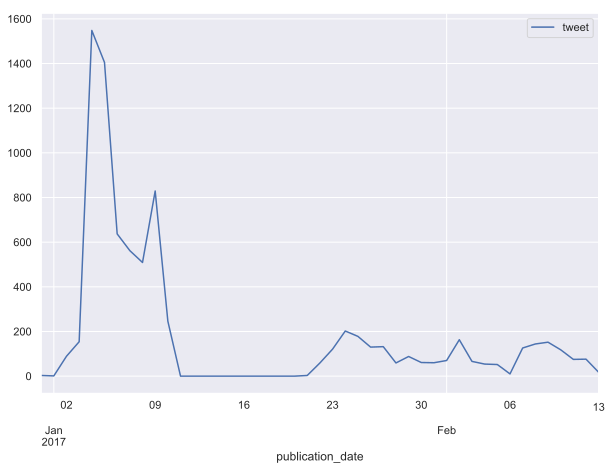

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
(df
     .groupby(pd.Grouper(key="publication_date", freq="D"))
     .count()
     .sort_values(by="publication_date")[["tweet"]]
     .plot(ax=ax));

Quais são os usuários que mais publicaram tweets, e quantos tweets publicaram?

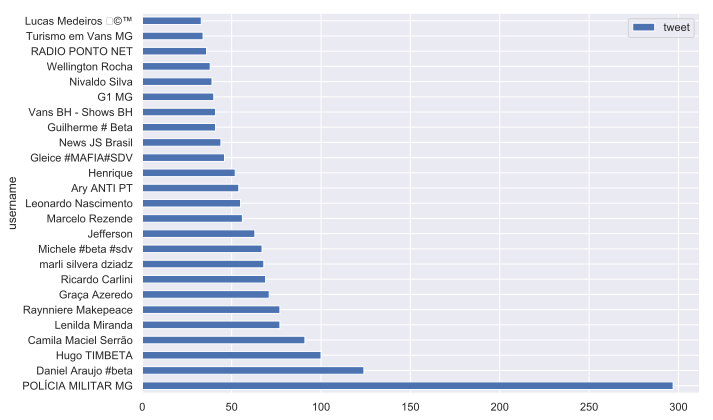

In [43]:
fig, ax = plt.subplots(figsize=(10, 7))
(df
     .groupby("username")
     .agg({"tweet": "count"})
     .sort_values(by="tweet", ascending=False)
     .head(25).plot.barh(ax=ax));

**Distribuição de tweets**

Como em muitos datasets da vida real, aqui vemos um claro problema deste dataset: A distribuição temporal dos sentimentos dos tweets é bastante diferente para as duas classes. A partir do final de janeiro de 2017, não há praticamente mais nenhum exemplo de tweet classificado como negativo. Isso pode piorar bastante a generalização do modelo...

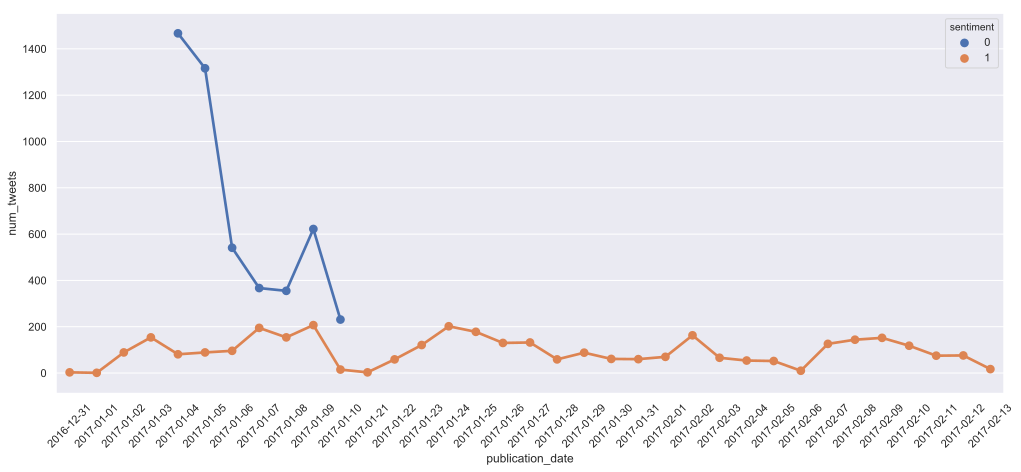

In [18]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.pointplot(data=(df
                        .assign(publication_date=df["publication_date"].dt.strftime("%Y-%m-%d"))
                        .groupby(["publication_date", "sentiment"])["tweet"]
                        .count()
                        .reset_index() 
                        .rename(columns={"tweet": "num_tweets"})),
              x="publication_date",
              y="num_tweets",
              hue="sentiment",
              ax=ax)
plt.xticks(rotation=45);


**Histograma do número de tweets e retweets por usuário**

A maioria dos usuários no dataset possui de 1 a 3 tweets. A quantidade de retweets também é assimétrica para poucos tweets. Nesse modelo não utilizaremos a quantidade de retweets, apenas o texto do tweet.

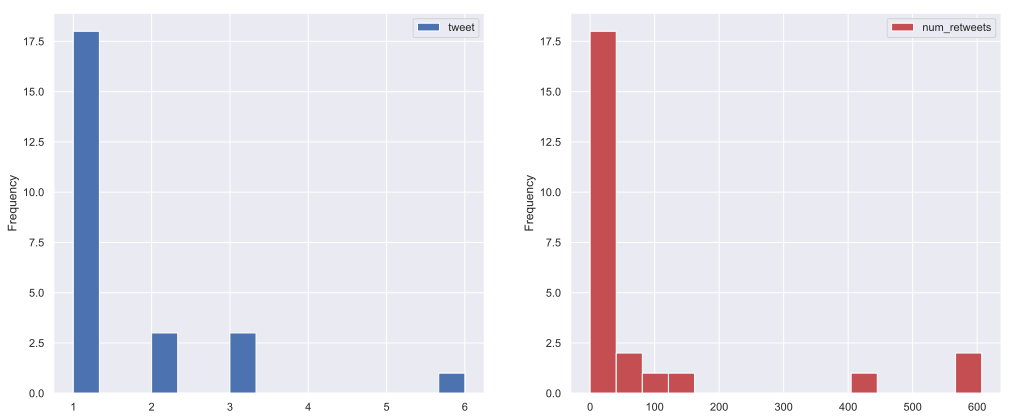

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
(df
     .groupby("username")
     .agg({"tweet": "count"})
     .head(25).plot.hist(ax=ax[0], bins=15))
(df
     .groupby("username")
     .agg({"num_retweets": "sum"})
     .head(25).plot.hist(ax=ax[1], bins=15, color="r"));

**ECDF da quantidade de tweets e retweets**

A ECDF de tweets nos dá bem mais informações sobre os nossos dados do que um histograma. De primeira já conseguimos observar que praticamente 95% de toda a base de usuários possui menos de 10 tweets e que há outliers de usuários com algo próximo a 300 tweets.

Já a ECDF da quantidade de retweets é um pouco diferente, embora também percebemos que cerca de 90% da base tem menos de 125 retweets, e também há outliers, o que é esperado.

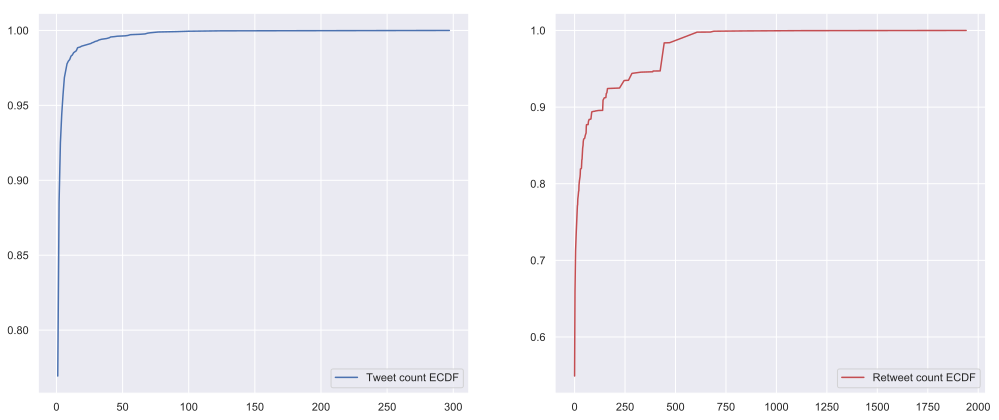

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
tweet_count = (df
                .groupby("username")
                .agg({"tweet": "count"})["tweet"].sort_values().values)
retweet_count = (df["num_retweets"].sort_values().values)

tweet_count_ecdf, retweet_count_ecdf = (map(ECDF, [tweet_count, retweet_count]))
ax[0].plot(tweet_count, tweet_count_ecdf(tweet_count), color="b")
ax[1].plot(retweet_count, retweet_count_ecdf(retweet_count), color="r")
ax[0].legend(labels=["Tweet count ECDF"], loc=4)
ax[0].get_legend().legendHandles[0].set_color("b")
ax[1].legend(labels=["Retweet count ECDF"], loc=4)
ax[1].get_legend().legendHandles[0].set_color("r");

### 2. A *pipeline* de treino

A biblioteca `fklearn` já possui alguns *learners* pré implementados. Neste caso, vamos utilizar o `nlp_logistic_classification_learner`. Este é um modelo básico para classificação de texto que junta um Tfidf seguido de uma regressão logística.

In [21]:
from fklearn.training.classification import nlp_logistic_classification_learner
from fklearn.training.pipeline import build_pipeline
from fklearn.training.utils import log_learner_time

def training_pipeline(text_cols, target_column, vectorizer_params, logistic_params):
    return log_learner_time(
        build_pipeline(
            nlp_logistic_classification_learner(
                text_feature_cols=text_cols,
                target=target_column,
                vectorizer_params=vectorizer_params,
                logistic_params=logistic_params
            )
        ), "tweet_sentiment_analysis")


**Parâmetros do Tfidf e da regressão logística**

Vamos alterar alguns parâmetros do `TfidfVectorizer`, e da `LogisticRegression`

In [22]:
# Check docs here https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer_params =  dict(decode_error="replace",
                          lowercase=True,
                          stop_words=nltk.corpus.stopwords.words("portuguese"),
                          ngram_range=(1, 3),
                          strip_accents=None)
# Check docs here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
logistic_params = dict(random_state=42,
                       n_jobs=-1,
                       solver="lbfgs")

### 3. Função de avaliação

Vamos avaliar usando as seguintes métricas:
- AUC
- LogLoss
- Precision
- Recall

E neste caso também iremos avaliar a performance do modelo no tempo. Neste caso, estamos separando o tempo em semanas,

In [23]:
from fklearn.validation.evaluators import auc_evaluator, logloss_evaluator, precision_evaluator, recall_evaluator, \
                                          combined_evaluators, temporal_split_evaluator

def tweet_eval(target_column, prediction_column, time_column):
    eval_args = dict(target_column=target_column,  prediction_column=prediction_column)
    basic_evaluator = combined_evaluators(evaluators=[
        auc_evaluator(**eval_args),
        logloss_evaluator(**eval_args),
        precision_evaluator(**eval_args),
        recall_evaluator(**eval_args)
    ])
    
    final_evaluator = combined_evaluators(evaluators=[
        basic_evaluator,
        temporal_split_evaluator(eval_fn=basic_evaluator, time_col=time_column, time_format="%Y-%U") # Weekly
    ])
    return final_evaluator


### 4. Separação dos dados de treino e validação

Vamos fazer a separação entre treino e validação usando `space_time_split_dataset`. A coluna do tempo neste modelo é `publication_date`, e o "espaço" é `username`: O propósito dessa avaliação no tempo e espaço é garantir a robustez do modelo para generalização.

In [24]:
dict(time_min=df["publication_date"].min(),
     time_max=df["publication_date"].max(),
     unique_users=df["username"].unique().shape)

{'time_min': Timestamp('2016-12-31 18:51:58+0000', tz='UTC'),
 'time_max': Timestamp('2017-02-13 11:03:33+0000', tz='UTC'),
 'unique_users': (3907,)}

In [25]:
from fklearn.preprocessing.splitting import space_time_split_dataset

train_set, intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout = \
                                        space_time_split_dataset(df,
                                                 train_start_date="2016-12-31",
                                                 train_end_date="2017-01-10",
                                                 holdout_end_date="2017-02-13",
                                                 split_seed=42,
                                                 space_holdout_percentage=0.2,
                                                 space_column="username",
                                                 time_column="publication_date")

(train_set.shape,
 intime_outspace_hdout.shape, 
 outime_inspace_hdout.shape,
 outime_outspace_hdout.shape)

((4589, 5), (1148, 5), (2445, 5), (205, 5))

In [26]:
holdout_set = pd.concat((intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout))

(train_set.shape,
 holdout_set.shape)

((4589, 5), (3798, 5))

### 5. Juntando tudo e construindo o modelo

Criando a pipeline de treino e a função de avaliação

In [27]:
train_fn = training_pipeline(text_cols=["tweet"], target_column="sentiment", 
                             vectorizer_params=vectorizer_params, logistic_params=logistic_params)

eval_fn = tweet_eval(target_column="sentiment",prediction_column="prediction", time_column="publication_date")

Treinando o modelo no `train_set`

In [28]:
predict_function, training_scored, training_logs = train_fn(train_set)
training_evaluation = eval_fn(training_scored)

Avaliando no `holdout_set`

In [29]:
holdout_scored = predict_function(holdout_set)
holdout_evaluation = eval_fn(holdout_scored)

In [30]:
predict_function(pd.DataFrame({"tweet": ["eu sou um tweet de Minas Gerais..."]}))

,tweet,prediction
0,eu sou um tweet de Minas Gerais...,0.201455


### 6. Visualizando a performance do modelo

Ao invés de olhar manualmente os logs (dentro dos dicionários `training_evaluation` e `holdout_evaluation`), podemos usar as funções de extração do `fklearn` para facilitar a visualização desses dados.

Abaixo, criamos um `base_extractor` que irá extrair as 4 colunas com as métricas básicas que usamos (auc, logloss, precision, recall).

Já resultado da avaliação temporal que fizemos estará disponível nas chaves da forma `"split_evaluator__publication_date_"`. Criamos então uma função que mapeia todos os splits feitos e retorna um `split_evaluator_extractor`. Essa função é chamada de `create_year_week_extractor`.

In [35]:
from fklearn.metrics.pd_extractors import *
eval_auc_col =  "auc_evaluator__sentiment"
eval_logloss_col = "logloss_evaluator__sentiment"
eval_precision_col =  "precision_evaluator__sentiment"
eval_recall_col = "recall_evaluator__sentiment"

base_extractor = combined_evaluator_extractor(base_extractors=[evaluator_extractor(evaluator_name=eval_auc_col),
                                                               evaluator_extractor(evaluator_name=eval_logloss_col),
                                                               evaluator_extractor(evaluator_name=eval_precision_col),
                                                               evaluator_extractor(evaluator_name=eval_recall_col)])
# Create a split evaluator based on the publication date available for a df_evaluation dataframe
def create_year_week_extractor(df_evaluation):
    year_week_splits = sorted((k.replace("split_evaluator__publication_date_", "") for k in df_evaluation.keys() if "publication_date" in k))
    return split_evaluator_extractor(split_col="publication_date", split_values=year_week_splits, base_extractor=base_extractor)

**Treino**

In [36]:
training_evaluation.keys()

dict_keys(['auc_evaluator__sentiment', 'logloss_evaluator__sentiment', 'precision_evaluator__sentiment', 'recall_evaluator__sentiment', 'split_evaluator__publication_date_2017-02', 'split_evaluator__publication_date_2017-01', 'split_evaluator__publication_date_2016-52'])

In [37]:
# Por padrão, as métricas precision e recall consideram um threshold de 0.5
base_extractor(training_evaluation)

,auc_evaluator__sentiment,logloss_evaluator__sentiment,precision_evaluator__sentiment,recall_evaluator__sentiment
0,0.992381,0.201786,1.0,0.788827


Métricas ao longo do tempo

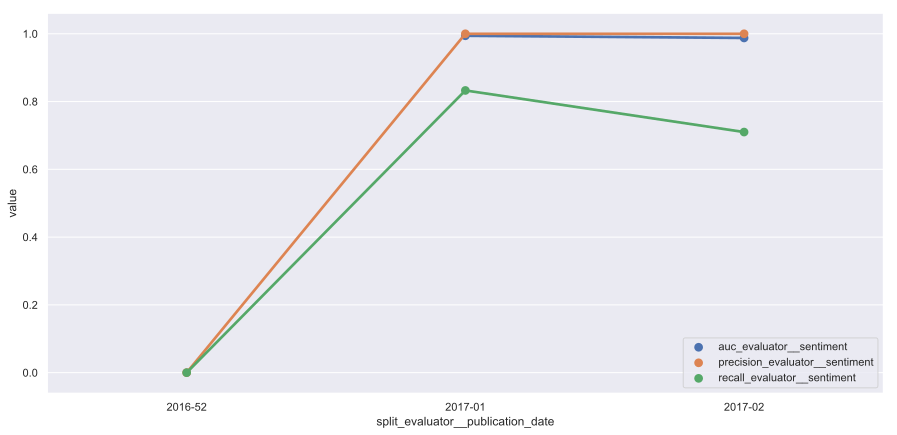

In [38]:
yweek_extractor_train = create_year_week_extractor(training_evaluation)

fig, ax = plt.subplots(figsize=(15, 7))

sns.pointplot(data=(yweek_extractor_train(training_evaluation)
                          .melt(id_vars=["split_evaluator__publication_date"],
                                value_vars=[eval_auc_col, eval_precision_col, eval_recall_col],
                                var_name="metric")),
              x="split_evaluator__publication_date",
              y="value",
              hue="metric",
              ax=ax)
ax.legend(loc=4);

**Holdout**

In [39]:
holdout_evaluation.keys()

dict_keys(['auc_evaluator__sentiment', 'logloss_evaluator__sentiment', 'precision_evaluator__sentiment', 'recall_evaluator__sentiment', 'split_evaluator__publication_date_2017-01', 'split_evaluator__publication_date_2017-02', 'split_evaluator__publication_date_2017-04', 'split_evaluator__publication_date_2017-05', 'split_evaluator__publication_date_2017-06', 'split_evaluator__publication_date_2017-07', 'split_evaluator__publication_date_2017-03'])

In [40]:
# Por padrão, as métricas precision e recall consideram um threshold de 0.5
base_extractor(holdout_evaluation)

,auc_evaluator__sentiment,logloss_evaluator__sentiment,precision_evaluator__sentiment,recall_evaluator__sentiment
0,0.954687,0.701487,1.0,0.450836


Métricas ao longo do tempo

Lembre-se que anteriormente vimos que não havia mais exemplos com `sentiment == 0` após o mês de janeiro. Aqui conseguimos perceber isto, pois o AUC fica com valor NaN após Fevereiro de 2017...

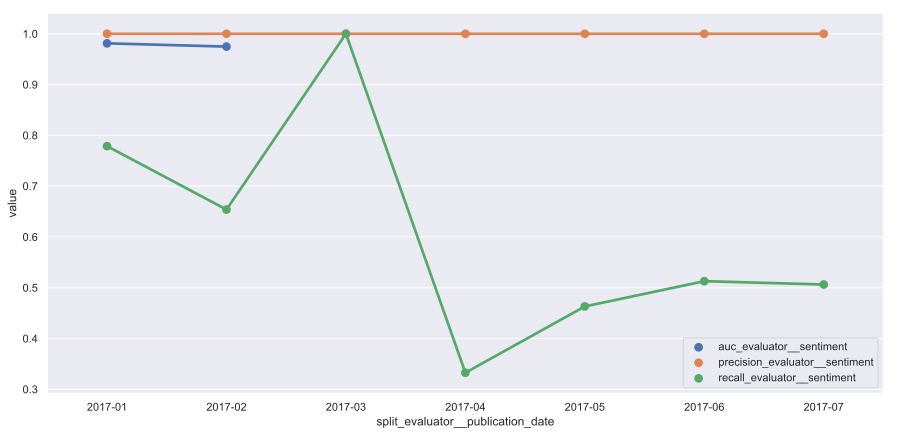

In [41]:
yweek_extractor_holdout = create_year_week_extractor(holdout_evaluation)

fig, ax = plt.subplots(figsize=(15, 7))

sns.pointplot(data=(yweek_extractor_holdout(holdout_evaluation)
                          .melt(id_vars=["split_evaluator__publication_date"],
                                value_vars=[eval_auc_col, eval_precision_col, eval_recall_col],
                                var_name="metric")),
              x="split_evaluator__publication_date",
              y="value",
              hue="metric",
              ax=ax)
ax.legend(loc=4);

**Curva *precision-recall***

Os valores de *precision* e *recall* vimos acima consideram um `threshold = 0.5`, o que nem sempre é o melhor dos casos. Geralmente em casos onde as classes são desbalanceadas, é recomendado olhar a curva *precision-recall*, que permite obter mais insights sobre o comportamento do modelo. Podemos usar os dataframes retornados pela pipeline de treino do `fklearn`  (neste caso `training_scored` e `holdout_scored`) para visualizar essa curva, usando a função `precision_recall_curve`.

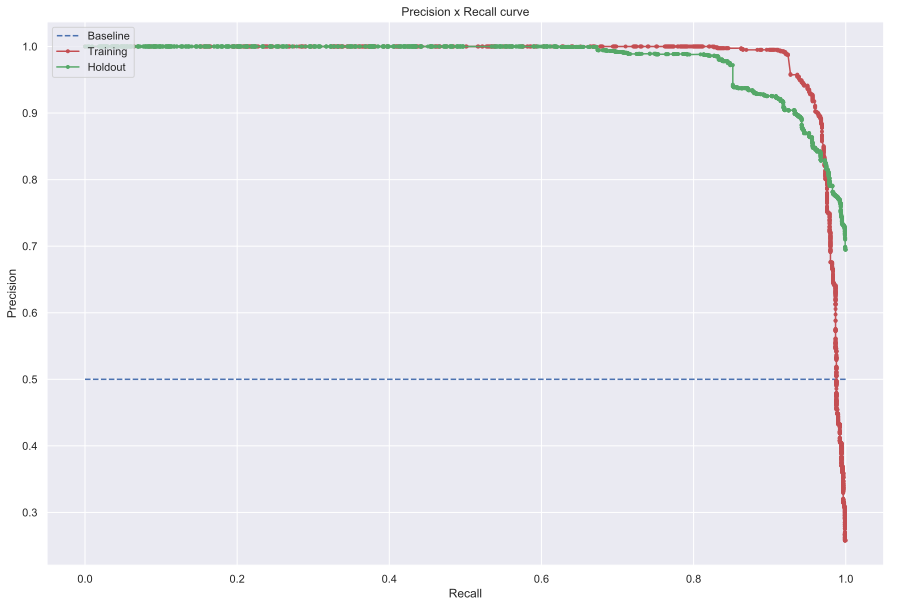

In [42]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve
precision_t, recall_t, _ = precision_recall_curve(training_scored["sentiment"], training_scored["prediction"])
precision_h, recall_h, _ = precision_recall_curve(holdout_scored["sentiment"], holdout_scored["prediction"])

# Plot curve
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot([0, 1], [0.5, 0.5], linestyle='--', color="b")
ax.plot(recall_t, precision_t, marker='.', color="r")
ax.plot(recall_h, precision_h, marker='.', color="g")
ax.set_xlabel("Recall"), ax.set_ylabel("Precision"), ax.set_title("Precision x Recall curve")
ax.legend(labels=["Baseline", "Training", "Holdout"], loc=2)
ax.get_legend().legendHandles[0].set_color("b"), ax.get_legend().legendHandles[1].set_color("r"), ax.get_legend().legendHandles[2].set_color("g");